In [1]:
root_dir = '/home2/glee/dissertation/1_tech_gen_impact/Transformer/Tech_Gen/'
import sys
sys.path.append(root_dir)

import copy
import gc
import os
import argparse
import math
import time
import pickle
import re
import multiprocess as mp
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
sys.path.append("/share/tml_package")
from tml import utils
from scipy import io
from tqdm import tqdm
from collections import OrderedDict

import torch
from torch.nn import functional as F
from torch.nn import DataParallel as DP
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
from accelerate import Accelerator
import pytorch_model_summary

import optuna
from optuna.samplers import RandomSampler, TPESampler
from optuna.integration import SkoptSampler

import numpy as np
import pandas as pd
import scipy.stats
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from data import TechDataset, CVSampler
from models import Transformer
from train_utils import EarlyStopping, perf_eval, objective_cv, build_model, train_model, validate_model_mp
from utils import token2class, DotDict

from cleantext.sklearn import CleanTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# PART 1: Configuration

In [2]:
args = argparse.Namespace(
    data_type="claim",
    data_file="collection_[H01L,H10][2017].csv",
    target_ipc="H01L",
    pred_type=None,
    n_TC=5,
    use_pretrained_tokenizer=False,
    do_train=None,
    do_tune=None,
    n_folds=None,
    max_epochs=150,
    use_accelerator=None,
    do_save=False,
    n_gpus=3,
    light=True,
    config_file=None,
    eval_train_set=False)

data_dir = os.path.join(root_dir, "data")
model_dir = os.path.join(root_dir, "models")
result_dir = os.path.join(root_dir, "results")
config_dir = os.path.join(root_dir, "configs")

if args.config_file is not None:
    config_file = args.config_file
else:
    config_file = os.path.join(config_dir, "configs_light.json") if args.light else os.path.join(config_dir, "configs.json")
configs = DotDict().load(config_file)
org_config_keys = {key: list(configs[key].keys()) for key in configs.keys()}

instant_configs = {key: value for (key, value) in vars(args).items() if value is not None} # if any argument passed when main.py executed
instant_configs_for_update = {configkey: {key: value for (key,value) in instant_configs.items() if key in org_config_keys[configkey]} for configkey in org_config_keys.keys()}
for key, value in configs.items():
    value.update(instant_configs_for_update[key])

regex_ipc = re.compile('[A-Z](?![\\D])')
if regex_ipc.match(configs.data.target_ipc) is None:
    configs.data.update({"target_ipc": "ALL"})
elif len(configs.data.target_ipc) > 5:
    configs.data.update({"target_ipc": configs.data.target_ipc[:4]})

if configs.model.model_type == "enc-pred-dec":
    configs.train.loss_weights["recon"] = configs.train.loss_weights["recon"] / sum(configs.train.loss_weights.values())
    configs.train.loss_weights["y"] = 1 - configs.train.loss_weights["recon"]
elif configs.model.model_type == "enc-pred":
    configs.train.loss_weights = {"recon": 0, "y": 1}
elif configs.model.model_type == "enc-dec":
    configs.train.loss_weights = {"recon": 1, "y": 0}

if configs.train.use_accelerator:
    accelerator = Accelerator()
    device_ids = list(range(torch.cuda.device_count()))
    device = accelerator.device

    configs.train.update({"accelerator": accelerator})
else:
    if torch.cuda.is_available():
        device_ids = list(range(torch.cuda.device_count()))
        gpu_usages = [np.sum([float(usage.split("uses")[-1].replace(" ","").replace("MB","")) for usage in torch.cuda.list_gpu_processes(id).split("GPU memory") if not usage=="" and "no processes are running" not in usage]) for id in device_ids]
        device_ids = np.argsort(gpu_usages)[:configs.train.n_gpus]
        device_ids = list(map(lambda x: torch.device('cuda', x),list(device_ids)))
        device = device_ids[0] # main device
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')
        device_ids = []

configs.data.update({"root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "result_dir": result_dir})
configs.train.update({"device": device,
                        "device_ids": device_ids,
                        "root_dir": root_dir,
                        "data_dir": data_dir,
                        "model_dir": model_dir,
                        "use_keywords": configs.data.use_keywords,
                        "early_stop_patience": int(0.3*configs.train.max_epochs)})
configs.model.update({"device": device,
                        "device_ids": device_ids,
                        "n_directions": 2 if configs.model.bidirec else 1,
                        "use_accelerator": configs.train.use_accelerator})

## Set hyperparameters for model training (To be TUNED)
if configs.train.do_train and configs.train.do_tune:
    n_layers = configs.model.n_layers = None
    d_embedding = configs.model.d_embedding = None
    d_hidden = configs.model.d_hidden = None
    d_latent = None
    learning_rate = configs.train.learning_rate = None
    batch_size = configs.train.batch_size = None
    config_name = "HPARAM_TUNING"
    final_model_path = None
else:
    n_layers = configs.model.n_layers
    d_embedding = configs.model.d_embedding
    d_hidden = configs.model.d_hidden
    d_latent = configs.model.n_enc_seq * configs.model.d_hidden

    key_components = {"data": ["target_ipc", "pred_type", "max_seq_len", "vocab_size"], "model": ["n_layers", "d_hidden", "d_embedding", "d_ff", "n_head", "d_head"], "train": ["learning_rate", "batch_size", "max_epochs"]}
    config_name = ""
    for key in key_components.keys():
        for component in key_components[key]:
            config_name += "["+str(configs[key][component])+component+"]"
    final_model_path = os.path.join(model_dir, f"[Final_model]{config_name}.ckpt")

configs.model.update({"d_latent": d_latent})
configs.train.update({"config_name": config_name,
                        "final_model_path": final_model_path})


# PART 2: Dataset setting

In [3]:
tstart = time.time()
dataset_config_name = "-".join([str(key)+"="+str(value) for (key,value) in configs.data.items() if key in org_config_keys["data"]])
dataset_path = os.path.join(data_dir, "pickled_dataset", "[tech_dataset]"+dataset_config_name+".pickle")
if os.path.exists(dataset_path) and args.do_save is False:
    print("Load pickled dataset...")
    with open(dataset_path, "rb") as f:
        tech_dataset = pickle.load(f)   # Load pickled dataset if dataset with same configuration already saved
    print("Pickled dataset loaded")
else:
    print("Make dataset...")
    tech_dataset = TechDataset(configs.data)
    with open(dataset_path, "wb") as f:
        tech_dataset.rawdata = None
        pickle.dump(tech_dataset, f)
tend = time.time()
print(f"{np.round(tend-tstart,4)} sec elapsed for loading patents for class [{configs.data.target_ipc}]")

Load pickled dataset...
Pickled dataset loaded
0.1201 sec elapsed for loading patents for class [H01L]


In [4]:
configs.model.update({"tokenizer": tech_dataset.tokenizer,
                        "n_enc_vocab": tech_dataset.tokenizer.get_vocab_size(),
                        "n_dec_vocab": tech_dataset.tokenizer.get_vocab_size(),
                        "n_enc_seq": tech_dataset.max_seq_len,
                        "n_dec_seq": tech_dataset.max_seq_len,
                        "n_outputs": 1 if configs.data.pred_type=="regression" else tech_dataset.n_outputs,
                        "i_padding": tech_dataset.tokenizer.token_to_id("<PAD>")})
configs.model.update({"d_latent": configs.model.n_enc_seq * configs.model.d_hidden})

In [5]:
sampler = CVSampler(tech_dataset, n_folds=configs.train.n_folds, test_ratio=0.1, stratify=True)
cv_idx = sampler.get_idx_dict()
print(f"#Samples\nTrain: {len(cv_idx[0]['train'])}, Validation: {len(cv_idx[0]['val'])}, Test: {len(cv_idx[0]['test'])}")

#Samples
Train: 25505, Validation: 6377, Test: 3543


# PART3:  Inference & visualization

In [5]:
final_model = build_model(configs.model)
if os.path.exists(final_model_path):
    best_states = torch.load(final_model_path)
else:
    raise Exception("Model need to be trained first")
converted_states = OrderedDict()
for k, v in best_states.items():
    if 'module' not in k:
        k = 'module.'+k
    else:
        k = k.replace('features.module.', 'module.features.')
    converted_states[k] = v
final_model.load_state_dict(converted_states)

del best_states
del converted_states
torch.cuda.empty_cache()

In [6]:
data_loader = DataLoader(tech_dataset, batch_size=128)

In [10]:
zs, ys, preds = [], [], []
newzs = []
for batch in tqdm(data_loader):
    x, xk, y = batch
    x, xk, y = x.to(device), xk.to(device), y.cpu().detach().numpy()
    
    enc_outputs, _ = final_model.module.encoder(xk.to(device))
    pred_outputs = final_model.module.predictor(enc_outputs)
    z = enc_outputs[:, -1, :].cpu().detach().numpy()
#     torch.cuda.empty_cache()
    aw = final_model.module.predictor.attn_weight(enc_outputs)
#     torch.cuda.empty_cache()
    newz = torch.bmm(aw.transpose(-1,1), enc_outputs).squeeze().cpu().detach().numpy()
    torch.cuda.empty_cache()
    pred = pred_outputs.cpu().detach().numpy()

    zs.append(z)
    ys.append(y)
    preds.append(pred.argmax(1))
    newzs.append(newz)
    
    torch.cuda.empty_cache()
                                                
zs = np.concatenate(zs)
ys = np.concatenate(ys)
preds = np.concatenate(preds)
newzs = np.concatenate(newzs)

100%|██████████| 277/277 [00:25<00:00, 10.86it/s]


## t-SNE

In [11]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [14]:
# tsne = TSNE(early_exaggeration=50, learning_rate="auto", n_iter=1000, init="random")
# z_tsne = tsne.fit_transform(zs)
# plt.scatter(z_tsne[:,0], z_tsne[:,1], c=ys, cmap="bwr")

/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.037762
[t-SNE] KL divergence after 250 iterations with early exaggeration: 203.491791
[t-SNE] KL divergence after 1000 iterations: 1.514721


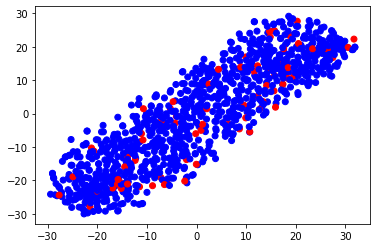

In [18]:
near_mean_idx = np.argsort(np.sum(abs(zs - np.mean(zs, axis=0)), axis=1))[:1000]
tsne = TSNE(early_exaggeration=30, learning_rate="auto", n_iter=1000, init="random", verbose=1, metric="cosine")
z_tsne = tsne.fit_transform(zs[near_mean_idx])

In [ ]:
plt.scatter(z_tsne[:,0], z_tsne[:,1], c=ys[near_mean_idx], cmap="bwr")

/home2/glee/.conda/envs/DL/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.025111
[t-SNE] KL divergence after 250 iterations with early exaggeration: 11952.074219
[t-SNE] KL divergence after 1000 iterations: 1.852226


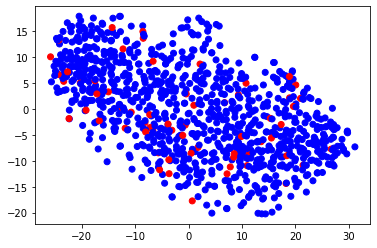

In [22]:
near_mean_idx = np.argsort(np.sum(abs(newzs - np.mean(newzs, axis=0)), axis=1))[:1000]
tsne = TSNE(early_exaggeration=1000, learning_rate="auto", n_iter=1000, init="random", verbose=1, metric="cosine")
newz_tsne = tsne.fit_transform(newzs[near_mean_idx])

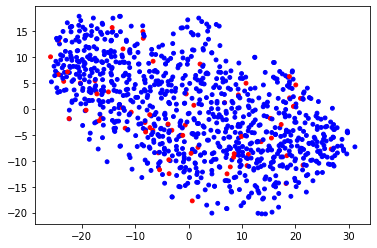

In [49]:
plt.scatter(newz_tsne[:,0], newz_tsne[:,1], c=ys[near_mean_idx], cmap="bwr", marker="o", s=15)